In [1]:
# CNTK 2.1 installálása Anaconda 3 alá itt található:
# https://docs.microsoft.com/en-us/cognitive-toolkit/setup-windows-python?tabs=cntkpy21
import IPython.display as D
from scipy.misc import imsave
import matplotlib.pyplot as plt
import numpy as np
import os
import cntk as C

In [2]:
# ha nincs megfelelő videókártya, vagy CUDA 8 támogatás, akkor csak CPU fog menni.
# Ekkor a batch noramlizációs változatok nem működnek
isGPUEnabled = True
if isGPUEnabled == True:
    C.device.try_set_default_device(C.device.gpu(0))
else:
    C.device.try_set_default_device(C.device.cpu())

In [3]:
# ahol a notebookhoz képest az adatbázis van, azt kell itt referálni
data_path = os.path.join('..','Examples','Image', 'Datasets','CarsDemo')
# model dimenziói
image_height = 40
image_width  = 40
num_channels = 3
num_classes  = 2

import cntk.io.transforms as xforms 
#
# Ezzel olvasható be a tréning és a teszt adat
#
def create_reader(map_file, train):
    print("Reading map file:", map_file)
    
    if not os.path.exists(map_file):
        raise RuntimeError("This tutorials depends...")

    transforms = []
    # tréning során laterálisan augmentálunk
    if train:
        transforms += [
            #xforms.crop(crop_type='center', side_ratio=0.83333333),
            xforms.crop(crop_type='randomside', side_ratio=0.833333),
            xforms.color(brightness_radius=0.2, contrast_radius=0.2, saturation_radius=0.1)
        ]
    else:
        transforms += [
            xforms.crop(crop_type='center', side_ratio=0.6667) 
        ]
    transforms += [
        xforms.scale(width=image_width, height=image_height, channels=num_channels, interpolations='linear')
    ]
    # deserializer
    return C.io.MinibatchSource(C.io.ImageDeserializer(map_file, C.io.StreamDefs(
        features = C.io.StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = C.io.StreamDef(field='label', shape=num_classes)      # and second as 'label'
    )))

In [4]:
# Readerek létrehozása
# Az eredeti adatbázis itt található:
# http://academictorrents.com/details/210dfc51f11dcfced602ad226962b7590e08c50a
reader_train = create_reader(os.path.join(data_path, 'car_training.txt'), True)
reader_test  = create_reader(os.path.join(data_path, 'car_testing.txt'), False) 

Reading map file: ..\Examples\Image\Datasets\CarsDemo\car_training.txt
Reading map file: ..\Examples\Image\Datasets\CarsDemo\car_testing.txt


In [5]:
#
# Hálózat tanítása és tesztelése
#
def train_and_evaluate(reader_train, reader_test, max_epochs, model_func):
    # Input variables denoting the features and label data
    input_var = C.input_variable((num_channels, image_height, image_width))
    label_var = C.input_variable((num_classes))
    # Normalize the input
    feature_scale = 1.0 / 256.0
    input_var_norm = C.element_times(feature_scale, input_var, name="features")  
    # apply model to input
    z = model_func(input_var_norm, out_dims = 2)

    # Training action

    # loss and metric
    ce = C.cross_entropy_with_softmax(z, label_var)
    pe = C.classification_error(z, label_var)
    # training config
    epoch_size     = 84227
    minibatch_size = 64
    # Set training parameters
    lr_per_minibatch       = C.learning_rate_schedule([0.01]*5 + [0.003]*5 + [0.001]*5 + [0.0003]*5 +[0.0001]*5 + [0.00003]*5 +[0.00001]*5+[0.000003], 
                                                      C.UnitType.sample, epoch_size)
    #momentum_time_constant = C.momentum_as_time_constant_schedule(-minibatch_size/np.log(0.9))
    momentum_time_constant = C.momentum_schedule(0.9)
    l2_reg_weight          = 0.001
    
    # trainer object
    learner = C.momentum_sgd(z.parameters, 
                             lr = lr_per_minibatch, 
                             momentum = momentum_time_constant, 
                             l2_regularization_weight=l2_reg_weight)
    
    #learner = C.adadelta(z.parameters, 
    #                         lr = lr_per_minibatch)
    
    progress_printer = C.logging.ProgressPrinter(tag='Training', num_epochs=max_epochs)
    trainer = C.Trainer(z, (ce, pe), [learner], [progress_printer])

    # define mapping from reader streams to network inputs
    input_map = {
        input_var: reader_train.streams.features,
        label_var: reader_train.streams.labels
    }

    C.logging.log_number_of_parameters(z) ; print()

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    for epoch in range(max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(min(minibatch_size, epoch_size - sample_count), 
                                               input_map=input_map) # fetch minibatch.
            trainer.train_minibatch(data)                                   # update model with it

            sample_count += data[label_var].num_samples                     # count samples processed so far
            
            # For visualization...            
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            batch_index += 1
        trainer.summarize_training_progress()
        
    # Evaluation action
    
    epoch_size     = 21057
    minibatch_size = 512

    # process minibatches and evaluate the model
    metric_numer    = 0
    metric_denom    = 0
    sample_count    = 0
    minibatch_index = 0

    while sample_count < epoch_size:
        current_minibatch = min(minibatch_size, epoch_size - sample_count)

        # Fetch next test min batch.
        data = reader_test.next_minibatch(current_minibatch, input_map=input_map)

        # minibatch data to be trained with
        metric_numer += trainer.test_minibatch(data) * current_minibatch
        metric_denom += current_minibatch

        # Keep track of the number of samples processed so far.
        sample_count += data[label_var].num_samples
        minibatch_index += 1

    print("")
    print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
    print("")
    
    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0)) 
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0)) 

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width
    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()
    
    return C.softmax(z)

In [6]:
# VGG like modell, de indításkor egy konvolúcióval és minden conv után batch normalizációval.
# Kimenet csak egy dense layeren keresztül, mert nincs sok komoly összefüggés
def create_vgg9_model(input, out_dims):
    with C.layers.default_options(activation=C.relu, init=C.glorot_uniform()):
        model = C.layers.Sequential([
            C.layers.For(range(3), lambda i: [
                C.layers.Convolution((3,3), [16,32,64][i], pad=True),
                C.layers.BatchNormalization(map_rank = 1),
                C.layers.Convolution((3,3), [16,32,64][i], pad=True),
                C.layers.BatchNormalization(map_rank = 1),
                C.layers.MaxPooling((2,2), strides=(2,2))
            ]),
            C.layers.Convolution((5,5), 64, pad=False, name='B'),
            C.layers.Convolution((1,1), 2, pad=False, name='C'),
            #C.layers.For(range(1), lambda : [
            #    C.layers.Dense(256, name='D1')
            #]),
            C.layers.Dense(out_dims, activation=None, name='Output')
        ])
    return model(input)

Training 175128 parameters in 30 parameter tensors.

Learning rate per sample: 0.01
Momentum per minibatch: 0.9
Finished Epoch[1 of 40]: [Training] loss = 0.329245 * 84227, metric = 14.23% * 84227 19.045s (4422.5 samples/s);
Finished Epoch[2 of 40]: [Training] loss = 0.195800 * 84227, metric = 7.62% * 84227 19.365s (4349.4 samples/s);
Finished Epoch[3 of 40]: [Training] loss = 0.178933 * 84227, metric = 6.91% * 84227 18.225s (4621.5 samples/s);
Finished Epoch[4 of 40]: [Training] loss = 0.175755 * 84227, metric = 6.79% * 84227 18.387s (4580.8 samples/s);
Finished Epoch[5 of 40]: [Training] loss = 0.171737 * 84227, metric = 6.41% * 84227 18.073s (4660.4 samples/s);
Learning rate per sample: 0.003
Finished Epoch[6 of 40]: [Training] loss = 0.110159 * 84227, metric = 4.08% * 84227 18.170s (4635.5 samples/s);
Finished Epoch[7 of 40]: [Training] loss = 0.106361 * 84227, metric = 3.89% * 84227 17.899s (4705.7 samples/s);
Finished Epoch[8 of 40]: [Training] loss = 0.104229 * 84227, metric = 3

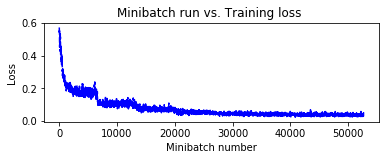

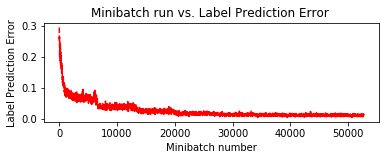

[Output('Softmax6667_Output_0', [#], [2]),
 Output('Output', [#], [2]),
 Output('C', [#], [2 x 1 x 1]),
 Output('B', [#], [64 x 1 x 1]),
 Output('Block6360_Output_0', [#], [64 x 5 x 5]),
 Output('Block6350_Output_0', [#], [64 x 10 x 10]),
 Output('Block6338_Output_0', [#], [64 x 10 x 10]),
 Output('Block6322_Output_0', [#], [64 x 10 x 10]),
 Output('Block6310_Output_0', [#], [64 x 10 x 10]),
 Output('Block6294_Output_0', [#], [32 x 10 x 10]),
 Output('Block6284_Output_0', [#], [32 x 20 x 20]),
 Output('Block6272_Output_0', [#], [32 x 20 x 20]),
 Output('Block6256_Output_0', [#], [32 x 20 x 20]),
 Output('Block6244_Output_0', [#], [32 x 20 x 20]),
 Output('Block6228_Output_0', [#], [16 x 20 x 20]),
 Output('Block6218_Output_0', [#], [16 x 40 x 40]),
 Output('Block6206_Output_0', [#], [16 x 40 x 40]),
 Output('Block6190_Output_0', [#], [16 x 40 x 40]),
 Output('Block6178_Output_0', [#], [16 x 40 x 40]),
 Output('features', [#], [3 x 40 x 40])]

In [7]:
pred_vgg = train_and_evaluate(reader_train, 
                              reader_test, 
                              max_epochs=40,
                              model_func=create_vgg9_model)

C.logging.get_node_outputs(pred_vgg)

In [8]:
pred_vgg.save("Cars_VGG_Big.dnn")

In [9]:
pred_vgg = C.load_model("Cars_VGG_Big.dnn")

In [10]:
# kép ellenőrzés

from PIL import Image as Image2

def eval_single_image(loaded_model, image_path):
    # load and format image (resize, RGB -> BGR, CHW -> HWC)
    try:
        img = Image2.open(image_path).convert("RGBA")
        
        if image_path.endswith("png"):
            temp = Image2.new("RGBA", img.size, (255, 255, 255))
            temp.paste(img, img)
            img = temp
        resized = img.crop((img.width/2-20, img.height/2-20, img.width/2+20, img.height/2+20))
        bgr_image = np.asarray(resized, dtype=np.float32)[..., [2, 1, 0]]
        hwc_format = np.ascontiguousarray(np.rollaxis(bgr_image, 2))

        # compute model output
        arguments = {loaded_model.arguments[0]: [hwc_format]}
        output = loaded_model.eval(arguments)

        # return softmax probabilities
        sm = C.softmax(output[0])
        return sm.eval()
    except FileNotFoundError:
        print("Could not open (skipping file): ", image_path)
        return ['None']
        
# Evaluates an image set using the provided model
def eval_test_images(test_map_file, loaded_model):
    num_images = sum(1 for line in open(test_map_file))
        
    print("Evaluating model output node '{0}' for {1} images.".format('prediction', num_images))

    pred_count = 0
    correct_count = 0
    np.seterr(over='raise')
    with open(test_map_file, "r") as input_file:
        for line in input_file:
            tokens = line.rstrip().split('\t')
            img_file = tokens[0]
            probs = eval_single_image(loaded_model, img_file)
            
            if probs[0]=='None':
                print("Eval not possible: ", img_file)
                continue

            pred_count += 1
            true_label = int(tokens[1])
            predicted_label = np.argmax(probs)
            if predicted_label == true_label:
                correct_count += 1

            if pred_count % 1000 == 0:
                print("Processed {0} samples ({1:.2%} correct)".format(pred_count, 
                                                                       (float(correct_count) / pred_count)))
            if pred_count >= num_images:
                break
    print ("{0} of {1} prediction were correct".format(correct_count, pred_count))
    return correct_count, pred_count, (float(correct_count) / pred_count)

In [11]:
eval_test_images(os.path.join(data_path, 'car_testing.txt'), pred_vgg)

Evaluating model output node 'prediction' for 21057 images.
Processed 1000 samples (97.90% correct)
Processed 2000 samples (97.75% correct)
Processed 3000 samples (98.03% correct)
Processed 4000 samples (97.97% correct)
Processed 5000 samples (98.08% correct)
Processed 6000 samples (98.02% correct)
Processed 7000 samples (98.04% correct)
Processed 8000 samples (98.02% correct)
Processed 9000 samples (98.11% correct)
Processed 10000 samples (98.21% correct)
Processed 11000 samples (98.25% correct)
Processed 12000 samples (98.31% correct)
Processed 13000 samples (98.38% correct)
Processed 14000 samples (98.47% correct)
Processed 15000 samples (98.48% correct)
Processed 16000 samples (98.48% correct)
Processed 17000 samples (98.40% correct)
Processed 18000 samples (98.46% correct)
Processed 19000 samples (98.52% correct)
Processed 20000 samples (98.53% correct)
Processed 21000 samples (98.52% correct)
20747 of 21057 prediction were correct


(20747, 21057, 0.9852780548036283)

In [12]:
# Clone the desired layers with fixed weights
feature_node = C.logging.find_by_name(pred_vgg, 'features')
last_node = C.logging.find_by_name(pred_vgg, 'C')
cloned_layers = C.combine([last_node.owner]).clone(C.CloneMethod.freeze, {feature_node: C.placeholder(name='features')})

image_input1 = C.input_variable((3,1024,1024))
cloned_out1 = cloned_layers(C.element_times(1/256.0, image_input1, name="features"))
z1 = C.layers.Dense(2, activation=None, name="out") (cloned_out1)

#image_input2 = C.input_variable((3,2048,2048))
#cloned_out2 = cloned_layers(C.element_times(1/256.0, image_input2, name="features"))
#z2 = C.layers.Dense(2, activation=None, name="out") (cloned_out2)

x1= C.logging.find_by_name(pred_vgg, 'Output').W.value[0][0][0][0]
y1= C.logging.find_by_name(pred_vgg, 'Output').W.value[1][0][0][0]
x2= C.logging.find_by_name(pred_vgg, 'Output').W.value[0][0][0][1]
y2= C.logging.find_by_name(pred_vgg, 'Output').W.value[1][0][0][1]

In [13]:
img = Image2.open("bigtest.png").convert("RGBA")
temp = Image2.new("RGBA", img.size, (255, 255, 255))
temp.paste(img, img)
img = temp
bgr_image = np.asarray(img, dtype=np.float32)[..., [2, 1, 0]]
hwc_format1 = np.ascontiguousarray(np.rollaxis(bgr_image, 2))
arguments1 = {cloned_out1.arguments[0]: [hwc_format1]}
img = Image2.open("bigtest2.png").convert("RGBA")
temp = Image2.new("RGBA", img.size, (255, 255, 255))
temp.paste(img, img)
img = temp
bgr_image = np.asarray(img, dtype=np.float32)[..., [2, 1, 0]]
hwc_format2 = np.ascontiguousarray(np.rollaxis(bgr_image, 2))
arguments2 = {cloned_out1.arguments[0]: [hwc_format2]}
img = Image2.open("bigtest3.png").convert("RGBA")
temp = Image2.new("RGBA", img.size, (255, 255, 255))
temp.paste(img, img)
img = temp
bgr_image = np.asarray(img, dtype=np.float32)[..., [2, 1, 0]]
hwc_format3 = np.ascontiguousarray(np.rollaxis(bgr_image, 2))
#arguments3 = {cloned_out2.arguments[0]: [hwc_format]}

In [14]:
small_size=124

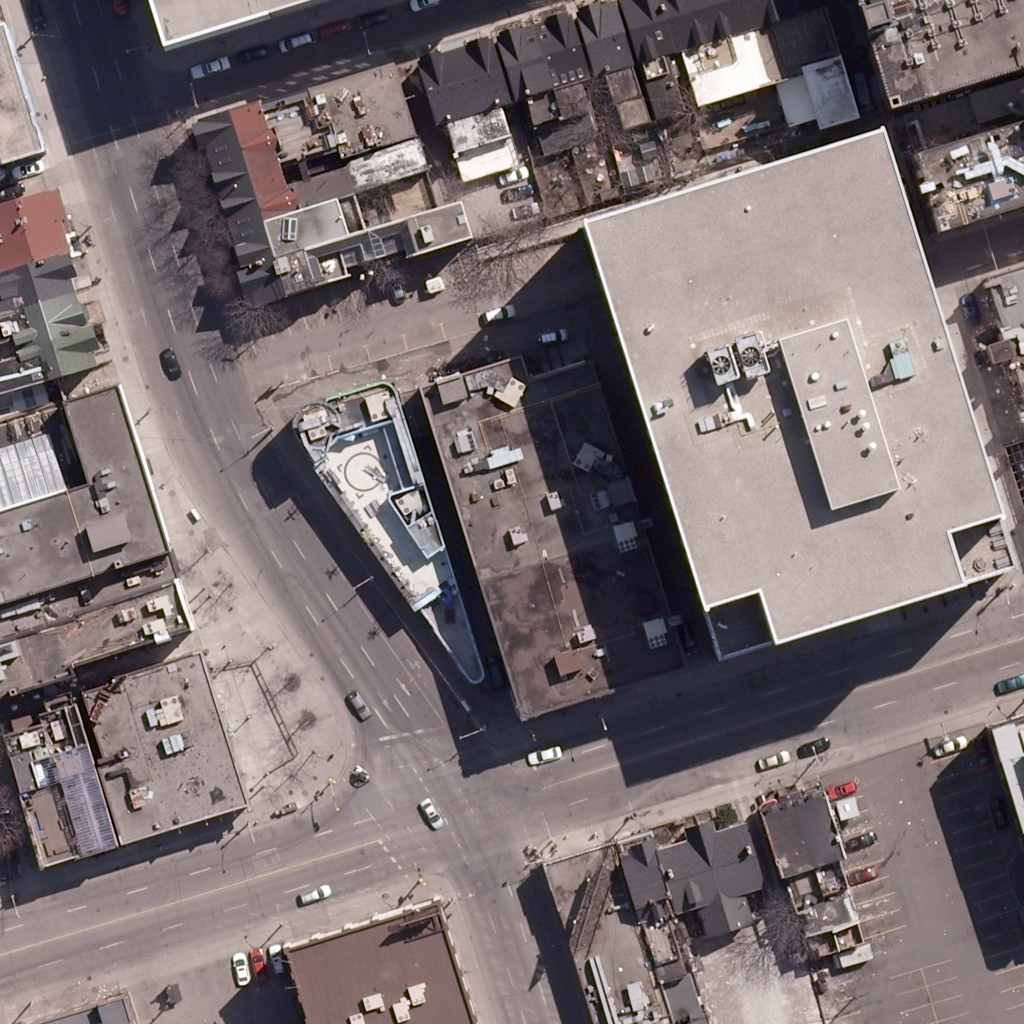

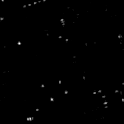

In [15]:
output = cloned_out1.eval(arguments1)
CXY=np.zeros([small_size, small_size])
for i in range(small_size):
    for j in range(small_size):
        CXY[i,j]=max((x1-x2)*output[0,0,i,j]+(y1-y2)*output[0,1,i,j]-5,0)
imsave("image.png", CXY)
D.display(D.Image('bigtest.png',width='512', height='512'))
D.display(D.Image('image.png',width='512', height='512'))

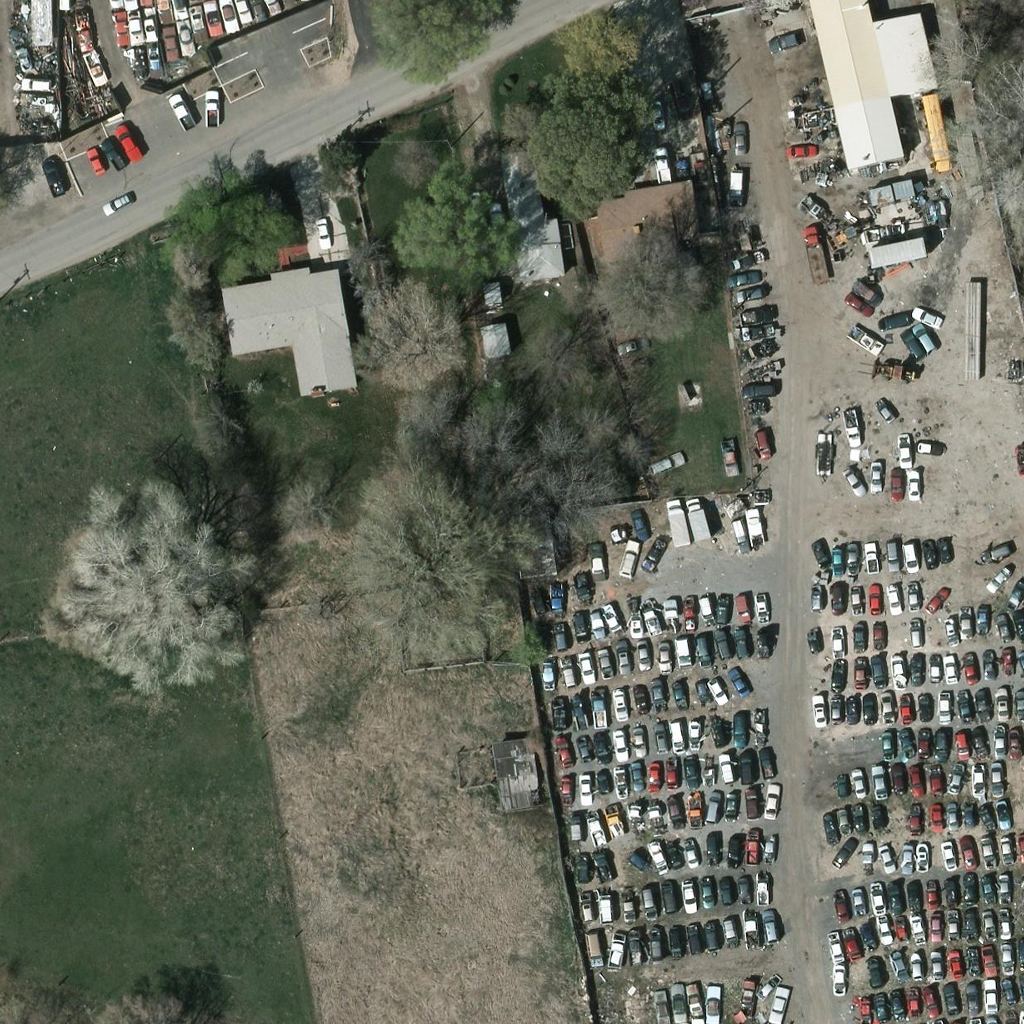

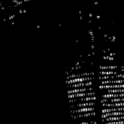

In [16]:
output = cloned_out1.eval(arguments2)
CXY=np.zeros([small_size, small_size])
for i in range(small_size):
    for j in range(small_size):
        CXY[i,j]=max((x1-x2)*output[0,0,i,j]+(y1-y2)*output[0,1,i,j]-5,0)
imsave("image.png", CXY)
D.display(D.Image('bigtest2.png',width='512', height='512'))
D.display(D.Image('image.png',width='512', height='512'))

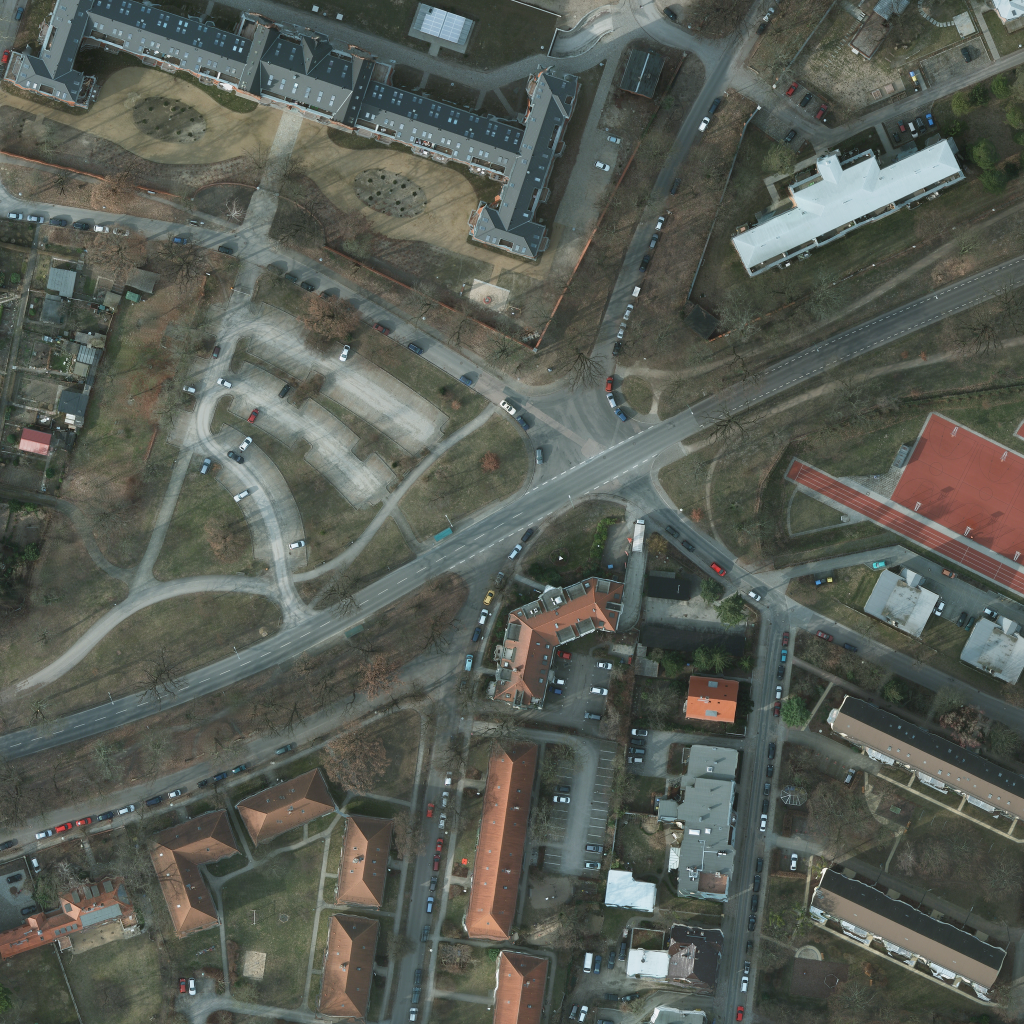

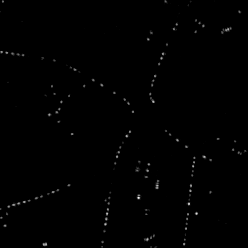

In [17]:
image_input2 = C.input_variable((3,2048,2048))
cloned_out2 = cloned_layers(C.element_times(1/256.0, image_input2, name="features"))
z2 = C.layers.Dense(2, activation=None, name="out") (cloned_out2)
arguments3 = {cloned_out2.arguments[0]: [hwc_format3]}
output = cloned_out2.eval(arguments3)
CXY=np.zeros([small_size*2, small_size*2])
for i in range(small_size*2):
    for j in range(small_size*2):
        CXY[i,j]=max(((x1-x2)*output[0,0,i,j]+(y1-y2)*output[0,1,i,j])-5,0)
imsave("image.png", CXY)
D.display(D.Image('bigtest3s.png',width='512', height='512'))
D.display(D.Image('image.png',width='512', height='512'))